### 初始化
定义工作目录 data_dir
*	insultation 聚类	
*	boundary 聚类	
* 	PC1 聚类	


In [1]:
import cooler
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from scipy.stats import mannwhitneyu
from mpl_toolkits.axes_grid1 import make_axes_locatable
import bioframe
import matplotlib.pyplot as plt
from matplotlib import font_manager
import cooltools
from cooltools import insulation
from skimage.filters import threshold_li, threshold_otsu
import bioframe
import bbi
import pyBigWig
from sklearn.isotonic import IsotonicRegression
#import pyComplexHeatmap

# 添加字体路径
font_manager.fontManager.addfont('/cluster2/home/futing/miniforge3/envs/hic/fonts/Arial.ttf')
arial_font = font_manager.FontProperties(fname='Arial.ttf')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] 
plt.rcParams['pdf.fonttype'] = 42

import hicstraw



In [38]:
TCGA=pd.read_csv('/cluster/home/tmp/GBM/RNA/subtype_TPM/result_centroid.txt',sep='\t')
meta=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/09insulation/meta_all.txt',sep='\t')

In [39]:
TCGA.head()

,Sample,Assigned_Subtype,ID,datset
0,home.tmp.gaorx.lft.20240830.analysis.iPSC.SRR1...,Classical,iPSC1,iPSC
1,home.tmp.gaorx.lft.20240830.analysis.iPSC.SRR1...,Classical,iPSC2,iPSC
2,home.tmp.gaorx.lft.20240830.analysis.iPSC.SRR1...,Neural,iPSC3,iPSC
3,home.tmp.gaorx.lft.20240830.analysis.NHA.SRR13...,Mesenchymal,NHA1,NHA
4,home.tmp.gaorx.lft.20240830.analysis.NHA.SRR13...,Mesenchymal,NHA2,NHA


In [40]:
TCGA=TCGA.iloc[:,1:]
#TCGA.reset_index(drop=True, inplace=True)
#TCGA.columns=['ID','dataset','TCGA','Neftel2019','Richards2021']
TCGA=TCGA.loc[~TCGA['datset'].isin(['NHA','NPC','iPSC','pHGG']),:]

In [ ]:
TCGA['dataset'].replace({'X42MGBA':'Xu2024',
                        'H4':'Xu2024',
                        'U343':'Xu2022',
                        'A172':'Xu2022'},inplace=True)
TCGA['sample']=TCGA['ID']

In [44]:
TCGA['datset']=TCGA['datset'].replace({'X42MGBA':'Xu2024',
                        'H4':'Xu2024',
                        'U343':'Xu2022',
                        'A172':'Xu2022'})

TCGA['sample']=TCGA['ID']
TCGA['sample'] = TCGA['sample'].apply(lambda x: x.replace("X", "")) #去掉42GBMA前面的X
TCGA['ID'] = TCGA['ID'].apply(lambda x: x.replace("X", "")) #去掉H4前面的H
TCGA['sample'].replace({'42MGBA1':'42MGBA',
                         '42MGBA2':'42MGBA'   ,
                          '42MGBA3':'42MGBA'  },inplace=True)
TCGA['sample']=TCGA['sample'].str.split('_').str[0]

/tmp/ipykernel_25844/1035602125.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  TCGA['sample'].replace({'42MGBA1':'42MGBA',


In [45]:
TCGA.head()

,Assigned_Subtype,ID,datset,sample
6,Mesenchymal,42MGBA1,Xu2024,42MGBA
7,Mesenchymal,42MGBA2,Xu2024,42MGBA
8,Mesenchymal,42MGBA3,Xu2024,42MGBA
9,Mesenchymal,H4_1,Xu2024,H4
10,Mesenchymal,H4_2,Xu2024,H4


In [58]:
#TCGA.to_csv('/cluster/home/futing/Project/GBM/HiC/09insulation/RNA_TCGA.txt',sep='\t',index=False)
TCGA=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/09insulation/RNA_TCGA.txt',sep='\t')

In [59]:
TCGA.shape,meta.shape

((147, 6), (74, 3))

In [60]:
meta.loc[~meta['sample'].isin(TCGA['sample']),:]

,sample,subtype,dataset
0,ts543,Proneural,Our
1,ts667,Proneural,Our
3,A172_2,Mesenchymal,unpublished
4,GB176,Unknown,Harewood et al
5,GB180,Unknown,Harewood et al
6,GB182,Unknown,Harewood et al
7,GB183,Unknown,Harewood et al
8,GB238,Unknown,Harewood et al
13,U251,Mesenchymal,Chen et al
16,G523,Unknown,Johnson et al


In [46]:
TCGA=pd.merge(TCGA,meta,on='sample')

In [47]:
meta['dataset'].unique()

array(['Our', 'Xu et al', 'unpublished', 'Harewood et al', 'Chen et al',
       'Cheng et al', 'Johnson et al', 'Xie et al', 'Mathur et al'],
      dtype=object)

In [48]:
TCGA.head()

,Assigned_Subtype,ID,datset,sample,subtype,dataset
0,Mesenchymal,42MGBA1,Xu2024,42MGBA,Mesenchymal,Cheng et al
1,Mesenchymal,42MGBA2,Xu2024,42MGBA,Mesenchymal,Cheng et al
2,Mesenchymal,42MGBA3,Xu2024,42MGBA,Mesenchymal,Cheng et al
3,Mesenchymal,H4_1,Xu2024,H4,Mesenchymal,Cheng et al
4,Mesenchymal,H4_2,Xu2024,H4,Mesenchymal,Cheng et al


In [49]:
TCGA.loc[TCGA['subtype']!=TCGA['Assigned_Subtype'],:]

,Assigned_Subtype,ID,datset,sample,subtype,dataset
14,Neural,P524.SF12681v4,Mathur2024,P524.SF12681v4,Classical,Mathur et al
16,Neural,P530.SF12822v10,Mathur2024,P530.SF12822v10,Proneural,Mathur et al
17,Neural,P530.SF12822v13,Mathur2024,P530.SF12822v13,Proneural,Mathur et al
18,Neural,P530.SF12822v14,Mathur2024,P530.SF12822v14,Proneural,Mathur et al
22,Neural,P530.SF12822v2,Mathur2024,P530.SF12822v2,Classical,Mathur et al
23,Neural,P530.SF12822v4,Mathur2024,P530.SF12822v4,Mesenchymal,Mathur et al
24,Neural,P530.SF12822v5,Mathur2024,P530.SF12822v5,Proneural,Mathur et al
27,Classical,G28,Xie2024,G28,Proneural,Xie et al
29,Classical,G62,Xie2024,G62,Unknown,Xie et al
30,Mesenchymal,G83,Xie2024,G83,Classical,Xie et al


In [36]:
TCGA.groupby('sample')['Assigned_Subtype'].apply(lambda x: x.nunique() == 1)

sample
A172               True
G1                 True
G120               True
G148               True
G163               True
G171               True
G181               True
G208               True
G213               True
G23                True
G275               True
G275R              True
G28                True
G318               True
G323               True
G351               True
G390               True
G394               True
G402               True
G402R              True
G412               True
G412R              True
G450               True
G452C              True
G452P              True
G457               True
G61                True
G62                True
G83                True
H4                 True
P524.SF12681v1     True
P524.SF12681v4     True
P524.SF12681v9     True
P530.SF12822v10    True
P530.SF12822v13    True
P530.SF12822v14    True
P530.SF12822v15    True
P530.SF12822v18    True
P530.SF12822v19    True
P530.SF12822v2     True
P530.SF12822v4     True
P530.SF12

In [ ]:
test=cooler.Cooler('/cluster/home/futing/Project/scHiC/lft/data/HIRES/SRR22514299.mcool::/resolutions/10000')
OPC=cooler.Cooler('/cluster/home/futing/Project/GBM/HiC/02data/01fastq/snm3C/2019/OPC_fil_10000.cool')

In [ ]:
data_dir = "/cluster/home/futing/Project/GBM/HiC/02data/03cool_order/50000"
cooler_file_list = glob.glob(f"{data_dir}/*.cool", recursive=True)

In [6]:
test.info

{'bin-size': 10000,
 'bin-type': 'fixed',
 'creation-date': '2019-04-09T19:51:45.791932',
 'format': 'HDF5::Cooler',
 'format-url': 'https://github.com/mirnylab/cooler',
 'format-version': 3,
 'generated-by': 'cooler-0.8.3',
 'genome-assembly': 'unknown',
 'metadata': {},
 'nbins': 309581,
 'nchroms': 25,
 'nnz': 57068032,
 'storage-mode': 'symmetric-upper',
 'sum': 254469353}

In [ ]:
OPC.pixels()[:]['count'].shape #nzz

(26626048,)

In [2]:
hic = hicstraw.HiCFile("/cluster/home/tmp/HGSOC/GSE201878_PEO1.hic")
print(hic.getChromosomes())
print(hic.getGenomeID())
print(hic.getResolutions())
result = hicstraw.straw('observed', 'KR', '/cluster/home/tmp/HGSOC/GSE201878_PEO1.hic', '1', '1', 'BP', 50000)
# for i in range(len(result)):

for i in range(10):
    print("{0}\t{1}\t{2}".format(result[i].binX, result[i].binY, result[i].counts))

[<hicstraw.chromosome object at 0x2b795f2be7f0>, <hicstraw.chromosome object at 0x2b795f2be130>, <hicstraw.chromosome object at 0x2b795f2be1b0>, <hicstraw.chromosome object at 0x2b795f4c7c70>, <hicstraw.chromosome object at 0x2b795f4c7d70>, <hicstraw.chromosome object at 0x2b795f4c7770>, <hicstraw.chromosome object at 0x2b795f4c77b0>, <hicstraw.chromosome object at 0x2b795f4c7670>, <hicstraw.chromosome object at 0x2b795f4c74b0>, <hicstraw.chromosome object at 0x2b795f4c7270>, <hicstraw.chromosome object at 0x2b795f4c73f0>, <hicstraw.chromosome object at 0x2b795f4c7470>, <hicstraw.chromosome object at 0x2b795f4c76b0>, <hicstraw.chromosome object at 0x2b795f4c7ab0>, <hicstraw.chromosome object at 0x2b795f4c75b0>, <hicstraw.chromosome object at 0x2b795f4c7bf0>, <hicstraw.chromosome object at 0x2b795f4c78f0>, <hicstraw.chromosome object at 0x2b795f4c7870>, <hicstraw.chromosome object at 0x2b7d301ef730>, <hicstraw.chromosome object at 0x2b795f001b30>, <hicstraw.chromosome object at 0x2b795f

In [1]:
import hicstraw

def detect_norms(hicfile, chrom="chr1", binsize=100000):
    candidate_norms = ["NONE", "VC", "VC_SQRT", "KR"]
    available = []
    hic = hicstraw.HiCFile(hicfile)
    for norm in candidate_norms:
        try:
            records = hic.getContactRecords(chrom, chrom, norm, "BP", binsize)
            if records:  # 能返回数据说明可用
                available.append(norm)
        except Exception:
            continue
    return available

norms = detect_norms("GSE201878_PEO1.hic")
print("Available norms:", norms)


: 

: 

: 

In [8]:
for chrom in hic.getChromosomes():
  print(chrom.name, chrom.length)

ALL 3099750
1 248956422
2 242193529
3 198295559
4 190214555
5 181538259
6 170805979
7 159345973
8 145138636
9 138394717
10 133797422
11 135086622
12 133275309
13 114364328
14 107043718
15 101991189
16 90338345
17 83257441
18 80373285
19 58617616
20 64444167
21 46709983
22 50818468
X 156040895
Y 57227415
M 16569
GL000008.2 209709
GL000009.2 201709
GL000194.1 191469
GL000195.1 182896
GL000205.2 185591
GL000208.1 92689
GL000213.1 164239
GL000214.1 137718
GL000216.2 176608
GL000218.1 161147
GL000219.1 179198
GL000220.1 161802
GL000221.1 155397
GL000224.1 179693
GL000225.1 211173
GL000226.1 15008
KI270302.1 2274
KI270303.1 1942
KI270304.1 2165
KI270305.1 1472
KI270310.1 1201
KI270311.1 12399
KI270312.1 998
KI270315.1 2276
KI270316.1 1444
KI270317.1 37690
KI270320.1 4416
KI270322.1 21476
KI270329.1 1040
KI270330.1 1652
KI270333.1 2699
KI270334.1 1368
KI270335.1 1048
KI270336.1 1026
KI270337.1 1121
KI270338.1 1428
KI270340.1 1428
KI270362.1 3530
KI270363.1 1803
KI270364.1 2855
KI270366.1 8320

### insulation 聚类

#### read and filter

In [ ]:
#all=pd.read_csv("/cluster/home/futing/Project/GBM/HiC/09insulation/cooltools_insulation/insul_50k_800k.tsv",sep="\t")
all=pd.read_csv("/cluster/home/futing/Project/GBM/HiC/09insulation/50k_800k/insul_50k_800k.tsv",sep="\t")
all=all.drop(columns=['A172_CPU','GB176','GB180','GB182','GB183','GB238','astro1','astro2','ipsc','NPC','pHGG','iPSC_new','NPC_new','ts543','ts667'])
# #all=all.dropna(how='all')
# all_fil=all.dropna(thresh=33) # 最多扔掉33个NA
# all_fil.shape

In [10]:
all.columns

Index(['42MGBA', 'A172_2', 'A172_CPU', 'A172', 'astro1', 'astro2', 'G120',
       'G148', 'G163', 'G171', 'G181', 'G1', 'G208', 'G213', 'G23', 'G275',
       'G275R', 'G28', 'G318', 'G323', 'G351', 'G390', 'G394', 'G402', 'G402R',
       'G412', 'G412R', 'G450', 'G452C', 'G452P', 'G457', 'G523', 'G567',
       'G583', 'G61', 'G62', 'G83', 'GB176', 'GB180', 'GB182', 'GB183',
       'GB238', 'GBM', 'H4', 'P455.SF11901', 'P475.SF12180', 'P498.SF12251',
       'P503.SF12518', 'P519.SF12601', 'P521.SF12631', 'P524.SF12681v1',
       'P524.SF12681v4', 'P524.SF12681v9', 'P529.SF12794v1-1',
       'P529.SF12794v6-1', 'P529.SF12794v8-1', 'P530.SF12822v10',
       'P530.SF12822v13', 'P530.SF12822v14', 'P530.SF12822v15',
       'P530.SF12822v18', 'P530.SF12822v19', 'P530.SF12822v2',
       'P530.SF12822v4', 'P530.SF12822v5', 'SW1088', 'ts543', 'ts667', 'U118',
       'U251', 'U343', 'U87'],
      dtype='object')

#### cor heatmap of insulation score

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 42 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'F', 'G', 'H', 'I', 'M', 'P', 'R', 'S', 'U', 'W', 'a', 'c', 'e', 'eight', 'five', 'four', 'hyphen', 'i', 'k', 'l', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 36, 37, 38, 41, 42, 43, 44, 48, 51, 53, 54, 56, 58, 68, 70, 72, 76, 78, 79,

<Figure size 1400x1000 with 0 Axes>

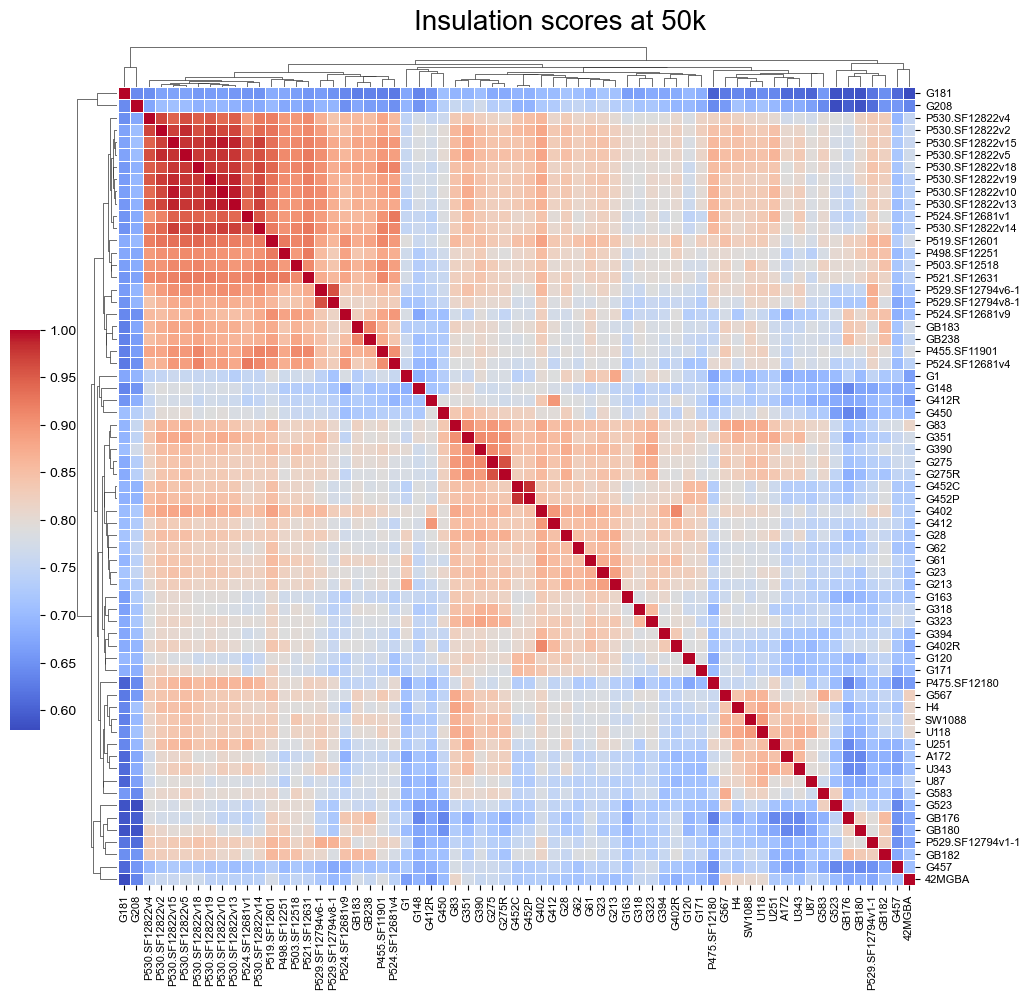

In [139]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sample_similarity = all.corr()
plt.figure(figsize=(14, 10))
g = sns.clustermap(sample_similarity, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5,
                    dendrogram_ratio=(0.05, 0.05),   
                    cbar_pos=(-0.05, 0.3, 0.03, 0.4))

# 设置标题
plt.suptitle('Insulation scores at 50k', fontsize=20, y=1.02)

# 获取矩阵的形状
rows, cols = sample_similarity.shape

# 手动设置刻度，确保它们位于每个格子的中心
g.ax_heatmap.set_xticks(np.arange(cols) + 0.5)
g.ax_heatmap.set_yticks(np.arange(rows) + 0.5)
for _, spine in g.ax_heatmap.spines.items():
    spine.set_visible(False)
    # 获取行和列的聚类结果（重新排序后的索引）
row_order = g.dendrogram_row.reordered_ind
col_order = g.dendrogram_col.reordered_ind

# 获取重新排序后的行和列标签
row_labels = [sample_similarity.index[i] for i in row_order]
col_labels = [sample_similarity.columns[i] for i in col_order]

# 设置 x 轴和 y 轴的标签
g.ax_heatmap.set_xticklabels(row_labels, fontsize=8) #rotation=45, ha='right', 
g.ax_heatmap.set_yticklabels(row_labels, fontsize=8)
'''
# 调整网格线的位置以确保与刻度对齐
g.ax_heatmap.grid(False)  # 禁用默认网格
g.ax_heatmap.hlines(np.arange(rows + 1) - 0.5, *g.ax_heatmap.get_xlim(), color='black', linewidth=0.5)
g.ax_heatmap.vlines(np.arange(cols + 1) - 0.5, *g.ax_heatmap.get_ylim(), color='black', linewidth=0.5)
'''

# 显示图形

plt.savefig(f'/cluster/home/futing/Project/GBM/HiC/09insulation/QC/insul_50_800k_all.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.5)

In [39]:
a1=cooler.Cooler('/cluster/home/futing/Project/GBM/HiC/02data/03cool/50000/A172_50000.cool')
a2=cooler.Cooler('/cluster/home/futing/Project/GBM/HiC/02data/03cool/50000/A172_CPU_50000.cool')

In [ ]:
print("Row order (after clustering):", row_order)
print("Row labels (after clustering):", row_labels)
print("Column order (after clustering):", col_order)
print("Column labels (after clustering):", col_labels)

Row order (after clustering): [69, 43, 50, 51, 52, 46, 48, 58, 56, 61, 62, 59, 63, 49, 57, 55, 60, 45, 47, 44, 53, 54, 40, 42, 27, 6, 9, 31, 14, 10, 11, 5, 4, 26, 1, 25, 32, 20, 22, 23, 3, 33, 7, 12, 16, 15, 18, 24, 13, 8, 17, 2, 19, 21, 66, 67, 28, 29, 30, 71, 41, 0, 68, 65, 70, 35, 34, 36, 37, 38, 39, 64]
Row labels (after clustering): ['U251', 'P455.SF11901', 'P524.SF12681v4', 'P524.SF12681v9', 'P529.SF12794v1-1', 'P503.SF12518', 'P521.SF12631', 'P530.SF12822v15', 'P530.SF12822v13', 'P530.SF12822v2', 'P530.SF12822v4', 'P530.SF12822v18', 'P530.SF12822v5', 'P524.SF12681v1', 'P530.SF12822v14', 'P530.SF12822v10', 'P530.SF12822v19', 'P498.SF12251', 'P519.SF12601', 'P475.SF12180', 'P529.SF12794v6-1', 'P529.SF12794v8-1', 'iPSC_new', 'NPC_new', 'G457', 'G1', 'G213R1', 'G61', 'G28', 'G213R2', 'G23', 'G181', 'G171', 'G452P', 'G120', 'G452C', 'G62', 'G402', 'G412', 'G412R', 'G163', 'G83', 'G208R1', 'G275', 'G323', 'G318', 'G390', 'G450', 'G275R', 'G208R2', 'G351', 'G148', 'G394', 'G402R', 'ts5

# Boundary strength

In [134]:
all_bound=pd.read_csv("/cluster/home/futing/Project/GBM/HiC/09insulation/50k_800k/BS_50k_800k.tsv",sep="\t")
all_bound=all_bound.drop(columns=['ts667','ts543','A172_CPU'])
all_bound=all_bound.iloc[:,1:]
#all_bound_fil=all_bound.loc[(all_bound != 0).any(axis=1),:]
all_bound=all_bound.dropna(thresh=33)
all_filled = all_bound.apply(lambda col: col.fillna(0))

In [128]:
all_filled.isna().sum()

P455.SF11901    0
P475.SF12180    0
P498.SF12251    0
P503.SF12518    0
P519.SF12601    0
               ..
ts543           0
ts667           0
U251            0
H4              0
42MGBA          0
Length: 68, dtype: int64

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 42 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'F', 'G', 'H', 'M', 'P', 'R', 'S', 'U', 'W', 'a', 'd', 'e', 'eight', 'five', 'four', 'g', 'h', 'hyphen', 'k', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 36, 37, 38, 41, 42, 43, 48, 51, 53, 54, 56, 58, 68, 71, 72, 74, 75, 78, 81,

<Figure size 1400x1000 with 0 Axes>

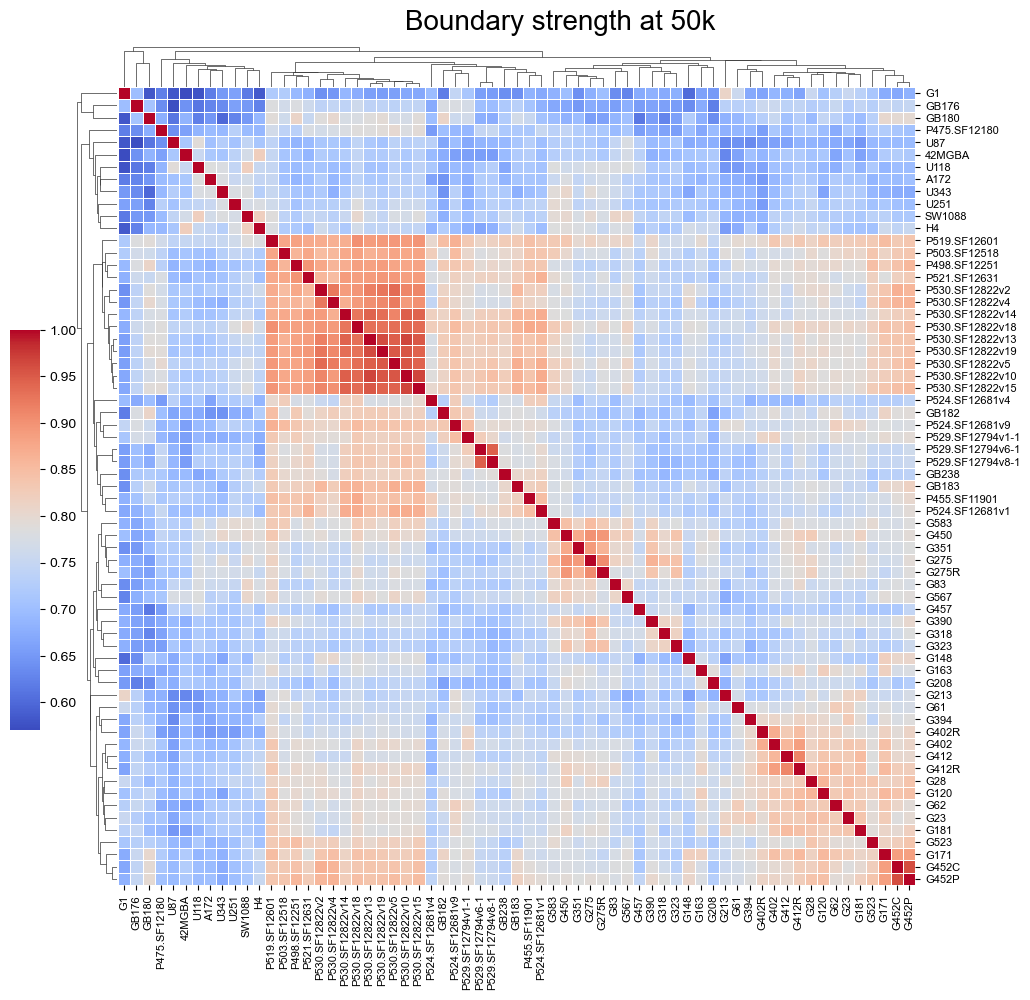

In [138]:



# 绘制热图
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sample_similarity = all_bound.corr()
plt.figure(figsize=(14, 10))
g = sns.clustermap(sample_similarity ,cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5,
                    dendrogram_ratio=(0.05, 0.05),   
                    cbar_pos=(-0.05, 0.3, 0.03, 0.4))

# 设置标题
plt.suptitle('Boundary strength at 50k', fontsize=20, y=1.02)

# 获取矩阵的形状
rows, cols = sample_similarity.shape

# 手动设置刻度，确保它们位于每个格子的中心
g.ax_heatmap.set_xticks(np.arange(cols) + 0.5)
g.ax_heatmap.set_yticks(np.arange(rows) + 0.5)
for _, spine in g.ax_heatmap.spines.items():
    spine.set_visible(False)
    # 获取行和列的聚类结果（重新排序后的索引）
row_order = g.dendrogram_row.reordered_ind
col_order = g.dendrogram_col.reordered_ind

# 获取重新排序后的行和列标签
row_labels = [sample_similarity.index[i] for i in row_order]
col_labels = [sample_similarity.columns[i] for i in col_order]

# 设置 x 轴和 y 轴的标签
g.ax_heatmap.set_xticklabels(row_labels,  fontsize=8) #rotation=45, ha='right',
g.ax_heatmap.set_yticklabels(row_labels, fontsize=8)

# 显示图形
#plt.show()
plt.savefig(f'/cluster/home/futing/Project/GBM/HiC/09insulation/QC/bound_50k_800k.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.5)

# PC1 聚类 

In [34]:
E1=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/06compartment/cooltools/E1_100k_norm.tsv',sep='\t')
#E1=E1.iloc[:,1:]
#E1=E1.dropna(how='all')
E1=E1.drop(columns=['astro1','astro2','ipsc','NPC','pHGG','iPSC_new','NPC_new','ts543','ts667']) #  ,'GBM','OPC',
#E1=E1.drop(columns=['GB176','GB180','GB182','GB183','GB238'])
E1.shape

(30894, 61)

In [119]:
print(E1.min().min(),E1.max().max())
# 每列的缺失值最小值和最大值
E1.isna().sum(axis=0).min(),E1.isna().sum(axis=0).max()

-3.388619005426285 3.5099601681876127


(623, 1025)

In [120]:
# 获取每列的最大值和最小值
max_values = E1.max()
min_values = E1.min()

# 将最大值和最小值合并为一个 DataFrame，作为一行
result = pd.DataFrame([min_values, max_values], index=['min', 'max'])
result

,42MGBA,A172_2,A172,G120,G148,G163,G171,G181,G1,G208,...,P530.SF12822v2,P530.SF12822v4,P530.SF12822v5,SW1088,ts543,ts667,U118,U251,U343,U87
min,-1.836796,-2.684964,-2.622284,-1.580560,-1.965380,-2.192511,-2.289014,-1.834615,-1.721341,-2.378806,...,-1.533941,-1.428553,-2.040867,-1.583668,-1.404132,-1.255385,-1.645826,-1.714062,-2.419889,-2.106185
max,1.699448,1.918523,2.096426,2.961625,2.595193,1.529842,2.020338,1.661485,1.444341,1.470038,...,1.411368,1.225130,1.520408,1.587173,1.602319,1.582913,2.041968,1.739805,1.873230,2.388293


In [ ]:
# 只保留至少3个不是NA的行
E1=E1.loc[E1.isna().sum(axis=1)<59,:]
E1.shape

(28079, 61)

In [ ]:
# 计算每行的方差，保留top20%的行
E1_var=E1.apply(lambda x: x.var(), axis=1)
fil=int(0.2*E1_var.shape[0])
E1_var.sort_values(ascending=False).index[0:fil+1]

Index([15791, 22986, 15779, 30584, 30587, 30585, 30507, 30434, 15792, 30495,
       ...
       17825,  5499, 22642, 11301, 10278, 12733, 22898, 22795, 26254,  7016],
      dtype='int64', length=5616)

In [3]:
#E1_fil=E1.loc[E1_var.sort_values(ascending=False).index[0:fil+1],:]
#E1_fil.to_csv('/cluster/home/futing/Project/GBM/HiC/09insulation/00plot/PC1/E1_down_100k_fil0.2.txt')
E1_fil=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/09insulation/00plot/PC1/E1_down_100k_fil0.2.txt',sep=',',index_col=0)


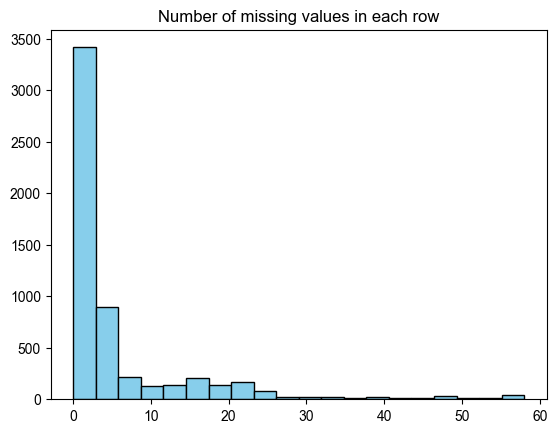

In [ ]:
nna=E1_fil.isna().sum(axis=1)
plt.hist(nna,bins=20,color='skyblue',edgecolor='black')
plt.title('Number of missing values in each row')
plt.show()

In [4]:
subtype=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/09insulation/subtype.txt',sep='\t',header=None)
dataset=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/09insulation/GBM_dataset.txt',sep='\t')
gad=pd.read_csv('/cluster/home/tmp/GBM/scHi-C/scGAD/c1_cluster.txt',sep=' ',header=None)
subtype.columns=['sample','subtype']
# subtype.index=subtype[0].values
# subtype=subtype.drop(columns=[0])
dataset=dataset.iloc[:,[0,2]]
merged=pd.merge(subtype,dataset,left_on='sample',right_on='file')
merged.drop(columns=['file'],inplace=True)
merged.to_csv('/cluster/home/futing/Project/GBM/HiC/09insulation/meta_GBM.txt',sep='\t')

In [ ]:
gad[0]=[x.split('.txt')[0] for x in gad[0]]
merged=pd.merge(subtype,gad,left_on='sample',right_on=0)
merged.drop(columns=[0],inplace=True)
merged.sort_values(by=1,inplace=True)
merged.to_csv('/cluster/home/futing/Project/GBM/HiC/09insulation/subtype_gad.txt',sep='\t',header=True,index=None)

In [32]:
meta=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/09insulation/meta_GBM.txt',sep='\t',index_col=0)
meta.head()

,sample,subtype,dataset
0,ts543,Proneural,Our
1,ts667,Proneural,Our
2,A172,Mesenchymal,Xu et al
3,A172_2,Mesenchymal,unpublished
4,GB176,Unknown,Harewood et al


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 50 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'F', 'G', 'H', 'M', 'N', 'P', 'R', 'S', 'T', 'U', 'W', 'a', 'b', 'c', 'e', 'eight', 'five', 'four', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'w', 'y', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 36, 37, 38, 41, 42, 43, 48

<Figure size 1400x1000 with 0 Axes>

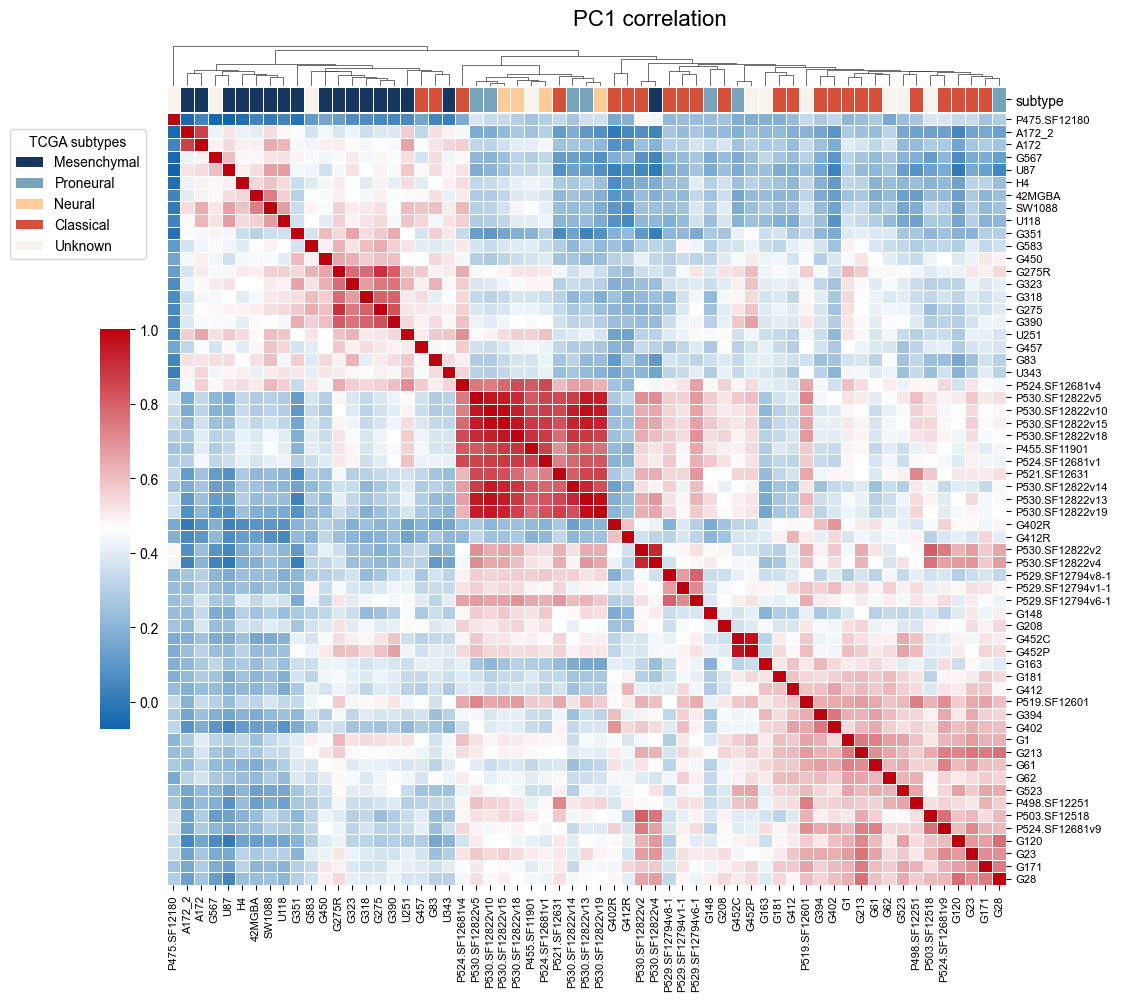

In [46]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch  # 用于创建图例颜色块
#c("#2B4251", "#B6D2D9", "#FCEEE3", "#5E887C") 黄绿色调
#("#16365F","#77A3BB","#F8F2ED","#D64F38")
# 自定义颜色映射
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#1065ad', 'white', '#bc020f'])
subtype_colors = {'Mesenchymal': "#16365F", 'Proneural': "#77A3BB", 
                  'Neural': '#FFCC99','Classical':"#D64F38", 'Unknown':"#F8F2ED"}
# 计算相似性矩阵
all_similarity = E1_fil.corr()

# 假设 row_colors 是一个包含每行颜色的 pandas Series
# row_colors 的索引应与 all_similarity 的索引一致，subtype_colors 是子类型对应的颜色字典

row_colors = subtype.set_index('sample')['subtype'].map(subtype_colors).reindex(all_similarity.index)
# 创建 clustermap，并传入行颜色条
plt.figure(figsize=(14, 10))
g = sns.clustermap(all_similarity, cmap=custom_cmap, annot=False, fmt=".2f", linewidths=0.5,
                   dendrogram_ratio=(0, 0.05),   
                   cbar_pos=(-0.05, 0.3, 0.03, 0.4),
                   col_colors=row_colors)  # 传入行颜色条

# 添加标题
plt.suptitle('PC1 correlation', fontsize=16, y=1.02)

# ----- 设置 x 轴和 y 轴的标签 -----
rows, cols = all_similarity.shape
g.ax_heatmap.set_xticks(np.arange(cols) + 0.5)
g.ax_heatmap.set_yticks(np.arange(rows) + 0.5)
for _, spine in g.ax_heatmap.spines.items():
    spine.set_visible(False)

# 获取重新排序后的行和列标签
row_order = g.dendrogram_row.reordered_ind
col_order = g.dendrogram_col.reordered_ind
row_labels = [all_similarity.index[i] for i in row_order]
col_labels = [all_similarity.columns[i] for i in col_order]

# 设置 x 轴和 y 轴的标签
g.ax_heatmap.set_xticklabels(row_labels, fontsize=8)  # 可根据需要调整 rotation=45, ha='right'
g.ax_heatmap.set_yticklabels(row_labels, fontsize=8)

# ----- 添加 row_colors 图例 -----
# 创建图例标签
legend_elements = [Patch(facecolor=color, label=subtype) for subtype, color in subtype_colors.items()]
plt.legend(handles=legend_elements, title="TCGA subtypes", bbox_to_anchor=(-3, 1.5), loc='upper left', borderaxespad=0)

plt.savefig(f'/cluster/home/futing/Project/GBM/HiC/09insulation/00plot/PC1/PC1_100k_subtype_0.2_no5_fil.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.5)


In [162]:
row_colors = subtype.set_index('sample')['subtype'].map(subtype_colors).reindex(all_similarity.index)
subtype_order=subtype.set_index('sample').reindex(E1_fil.columns)

In [ ]:
import PyComplexHeatmap
from PyComplexHeatmap import *
#Put annotations on the top
sample_similarity = E1.corr()
col_ha = HeatmapAnnotation(label=anno_label(subtype['subtype'], merge=True, rotation=45),
                               Subtype=anno_simple(subtype['subtype'], legend=True),label_side='right', axis=1)
                               #Tissue=df_cols.Tissue,)
plt.figure(figsize=(12, 20))
cm = ClusterMapPlotter(data=sample_similarity, top_annotation=col_ha,
                       show_rownames=True, show_colnames=False,row_names_side='left',
                       #col_split=df_cols.Family,
                       cmap='coolwarm', label='AUC',
                       rasterized=True, legend=True)
#plt.savefig("clustermap.pdf", bbox_inches='tight')
plt.show()

[Text(1, 0.5, 'G148'),
 Text(1, 1.5, 'ts543'),
 Text(1, 2.5, 'ts667'),
 Text(1, 3.5, 'P524.SF12681v4'),
 Text(1, 4.5, 'GB238'),
 Text(1, 5.5, 'GB183'),
 Text(1, 6.5, 'P455.SF11901'),
 Text(1, 7.5, 'P521.SF12631'),
 Text(1, 8.5, 'P530.SF12822v13'),
 Text(1, 9.5, 'P530.SF12822v19'),
 Text(1, 10.5, 'P524.SF12681v1'),
 Text(1, 11.5, 'P530.SF12822v10'),
 Text(1, 12.5, 'P530.SF12822v14'),
 Text(1, 13.5, 'P530.SF12822v5'),
 Text(1, 14.5, 'P530.SF12822v15'),
 Text(1, 15.5, 'P530.SF12822v18'),
 Text(1, 16.5, 'P530.SF12822v4'),
 Text(1, 17.5, 'GB180'),
 Text(1, 18.5, 'GB176'),
 Text(1, 19.5, 'GB182'),
 Text(1, 20.5, 'P503.SF12518'),
 Text(1, 21.5, 'P530.SF12822v2'),
 Text(1, 22.5, 'P519.SF12601'),
 Text(1, 23.5, 'P524.SF12681v9'),
 Text(1, 24.5, 'P529.SF12794v1-1'),
 Text(1, 25.5, 'P529.SF12794v6-1'),
 Text(1, 26.5, 'P529.SF12794v8-1'),
 Text(1, 27.5, 'P498.SF12251'),
 Text(1, 28.5, 'G452C'),
 Text(1, 29.5, 'G452P'),
 Text(1, 30.5, 'G208'),
 Text(1, 31.5, 'G61'),
 Text(1, 32.5, 'G1'),
 Text(1, 3

<Figure size 1400x1000 with 0 Axes>

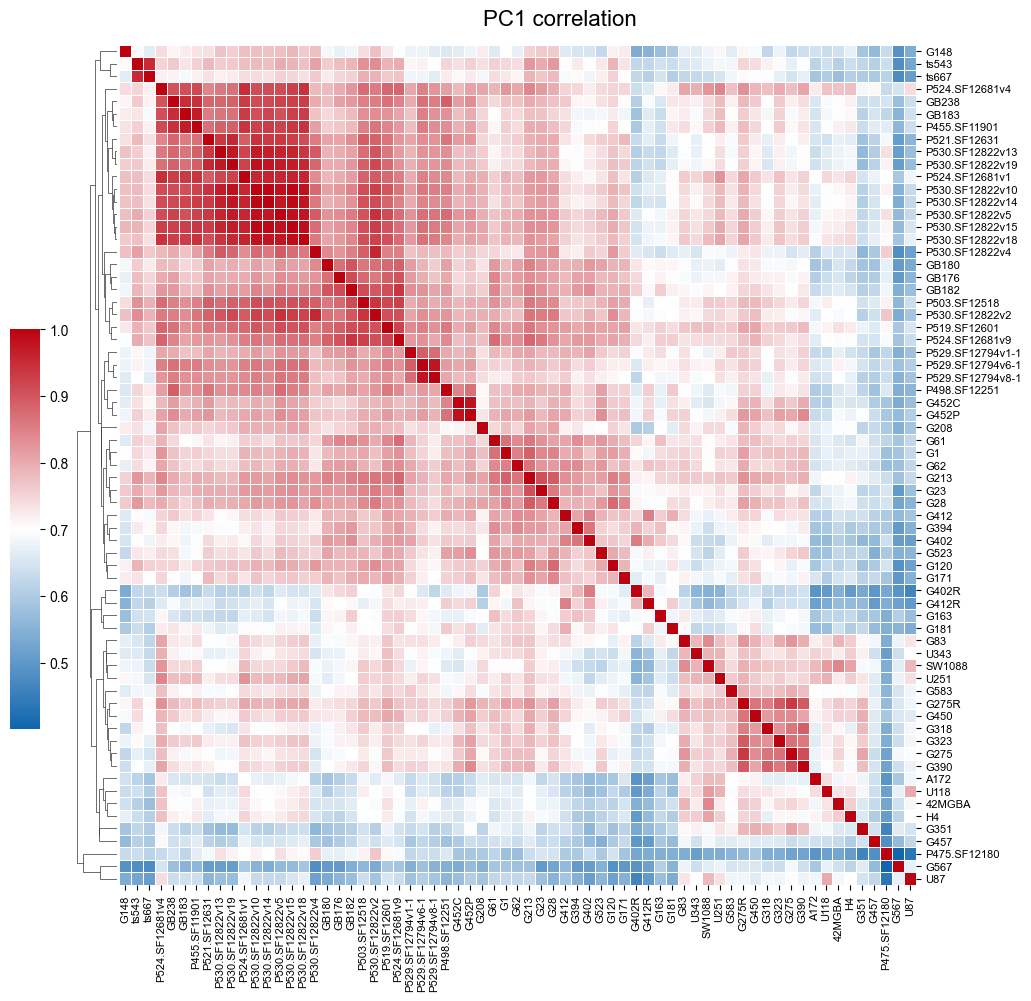

In [53]:
from matplotlib.colors import LinearSegmentedColormap


custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', ['#1065ad' ,'white', '#bc020f' ])
#custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', [ '#3064A9','white', '#B32C26'])
all_similarity = E1.corr()
# 为子类型创建颜色映射


plt.figure(figsize=(14, 10))
g = sns.clustermap(all_similarity ,cmap=custom_cmap, annot=False, fmt=".2f", linewidths=0.5,
                    dendrogram_ratio=(0.05, 0),   
                    cbar_pos=(-0.05, 0.3, 0.03, 0.4))
plt.suptitle('PC1 correlation', fontsize=16, y=1.02)

# ----- 设置 x 轴和 y 轴的标签 -----
rows, cols = all_similarity.shape
# 手动设置刻度，确保它们位于每个格子的中心
g.ax_heatmap.set_xticks(np.arange(cols) + 0.5)
g.ax_heatmap.set_yticks(np.arange(rows) + 0.5)
for _, spine in g.ax_heatmap.spines.items():
    spine.set_visible(False)

# 获取行和列的聚类结果（重新排序后的索引）
row_order = g.dendrogram_row.reordered_ind
col_order = g.dendrogram_col.reordered_ind
# 获取重新排序后的行和列标签
row_labels = [all_similarity.index[i] for i in row_order]
col_labels = [all_similarity.columns[i] for i in col_order]
# 设置 x 轴和 y 轴的标签
g.ax_heatmap.set_xticklabels(row_labels,  fontsize=8) #rotation=45, ha='right',
g.ax_heatmap.set_yticklabels(row_labels, fontsize=8)

# 显示图形

#plt.savefig(f'/cluster/home/futing/Project/GBM/HiC/09insulation/00plot/PC1/PC1_500k.pdf', format='pdf', dpi=300, bbox_inches='tight', pad_inches=0.5)

#### PCA 
输入 all_sig_U

In [33]:
meta.set_index('sample',inplace=True)
meta=meta.reindex(E1_fil.columns)
meta['dataset'] = pd.Categorical(meta['dataset'], categories=["Chen et al","Cheng et al","Johnson et al","Mathur et al","Xie et al","Xu et al","unpublished"], ordered=True)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import umap.umap_ as umap
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

data=E1_fil.T # 列是特征
data_imputed=data.fillna(0)
# imputer = SimpleImputer(strategy='mean')
# data_imputed = imputer.fit_transform(data)


pca = PCA(n_components=20, random_state=42)
data_pca = pca.fit_transform(data_imputed)
umap_instance = umap.UMAP(n_neighbors=15,min_dist=0.1,  n_components=2, random_state=42)
umap_transformed = umap_instance.fit_transform(data_pca)

# 对UMAP降维后的数据进行KMeans聚类
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(umap_transformed)
umaplabels = kmeans.labels_

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(data_pca)
pcalabels = kmeans.labels_


/cluster/home/futing/miniforge-pypy3/envs/hic/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [ ]:
pca_result=pd.DataFrame(data_pca,columns=[f'PC{i+1}' for i in range(20)])
pca_result.index=E1_fil.columns
pca_result['kmeans']=pcalabels
pca_result=pd.merge(pca_result,meta,left_index=True,right_index=True)
pca_result.to_csv('/cluster/home/futing/Project/GBM/HiC/09insulation/00plot/PC1/scatter/PC1_python_kmeans.txt',sep='\t')

In [42]:
umap_result=pd.DataFrame(umap_transformed,columns=[f'UMAP{i+1}' for i in range(2)])
umap_result.index=E1_fil.columns
umap_result['kmeans']=umaplabels
umap_result=pd.merge(umap_result,meta,left_index=True,right_index=True)
umap_result.to_csv('/cluster/home/futing/Project/GBM/HiC/09insulation/00plot/PC1/scatter/UMAP_python_kmeans.txt',sep='\t')

In [25]:
compare=pd.DataFrame({'PCA':pcalabels,'UMAP':umaplabels,'sample':E1_fil.columns})
compare=pd.merge(compare,meta,on='sample')

In [52]:
compare['UMAP'] = compare['UMAP'].replace({1: 2, 2: 1})

compare.loc[compare['PCA']!=compare['UMAP'],:]

,PCA,UMAP,sample,subtype,dataset
4,1,2,G148,Proneural,Xie et al
9,1,2,G208,Classical,Xie et al
36,1,0,P475.SF12180,Unknown,Mathur et al
37,1,0,P498.SF12251,Classical,Mathur et al
38,1,0,P503.SF12518,Unknown,Mathur et al
39,1,0,P519.SF12601,Unknown,Mathur et al
53,1,0,P530.SF12822v2,Classical,Mathur et al
54,1,0,P530.SF12822v4,Mesenchymal,Mathur et al


In [8]:
Rresult=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/09insulation/00plot/PC1/scatter/compare_R.txt',sep='\t')

In [ ]:

pca_result=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/09insulation/00plot/PC1/scatter/PC1_python_kmeans.txt',sep='\t',index_col=0)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 31 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'D', 'J', 'L', 'M', 'P', 'X', 'a', 'b', 'd', 'e', 'g', 'h', 'i', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'two', 'u', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 38, 39, 45, 47, 48, 51, 59, 68, 69, 71, 72, 74, 75, 76, 79, 81, 82, 83, 85, 86, 87, 88, 237]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 31 glyphs after
INFO:fontTools.subset:Gly

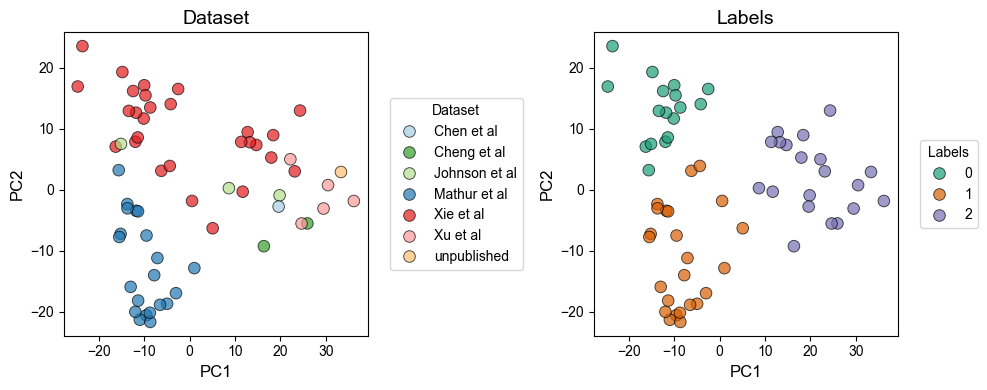

In [49]:

mypalette = ['#a6cee3','#33a02c','#b2df8a','#1f78b4','#e31a1c','#fb9a99','#fdbf6f']
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 左边的图：根据 'dataset' 上色
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], 
                hue=meta['dataset'], palette=mypalette, ax=axes[0],s=70, alpha=0.7, edgecolor='k')

axes[0].set_title('Dataset', fontsize=14)
axes[0].set_xlabel('PC1', fontsize=12)
axes[0].set_ylabel('PC2', fontsize=12)

# 右边的图：根据 'labels' 上色
sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], 
                hue=pcalabels, palette="Dark2", ax=axes[1],s=70, alpha=0.7, edgecolor='k')

axes[1].set_title('Labels', fontsize=14)
axes[1].set_xlabel('PC1', fontsize=12)
axes[1].set_ylabel('PC2', fontsize=12)

# 调整两个图例，统一放置在右边
# 第一个图例：Dataset
axes[0].legend(title='Dataset', bbox_to_anchor=(1.05, 0.5), loc='center left')

# 第二个图例：Labels
axes[1].legend(title='Labels', bbox_to_anchor=(1.05, 0.5), loc='center left')

# 调整布局
plt.tight_layout()
plt.savefig(f'/cluster/home/futing/Project/GBM/HiC/09insulation/00plot/PC1/scatter/PC1_python_kmeans.pdf', format='pdf', dpi=500, bbox_inches='tight', pad_inches=0.5)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 36 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'D', 'J', 'L', 'M', 'P', 'U', 'X', 'a', 'b', 'd', 'e', 'eight', 'five', 'g', 'h', 'i', 'l', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'seven', 'six', 'space', 't', 'two', 'u', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 24, 25, 26, 27, 28, 36, 38, 39, 45, 47, 48, 51, 56, 59, 68, 69, 71, 72, 74, 75, 76, 79, 81, 82, 83, 85, 86, 87, 88]
INFO:fontTools.subset:Closed glyph list ov

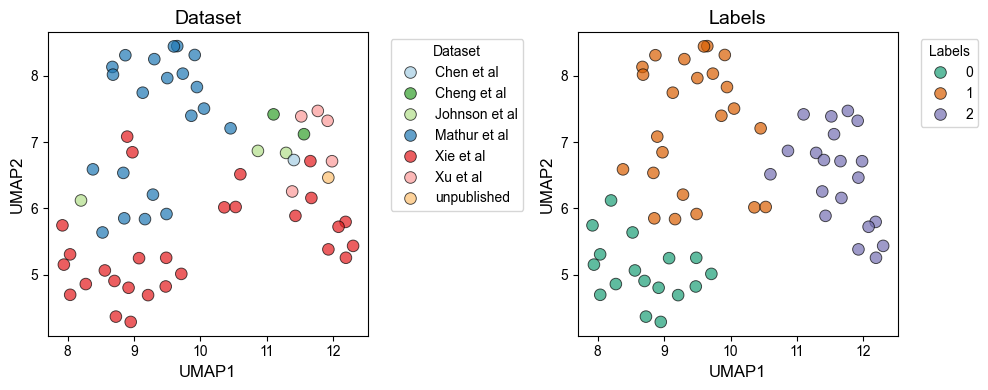

In [48]:

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# 左边的图：根据 'dataset' 上色
sns.scatterplot(x=umap_transformed[:, 0], y=umap_transformed[:, 1], 
                hue=meta['dataset'], palette=mypalette, ax=axes[0],s=70, alpha=0.7, edgecolor='k')

axes[0].set_title('Dataset', fontsize=14)
axes[0].set_xlabel('UMAP1', fontsize=12)
axes[0].set_ylabel('UMAP2', fontsize=12)

# 右边的图：根据 'labels' 上色
sns.scatterplot(x=umap_transformed[:, 0], y=umap_transformed[:, 1], 
                hue=labels, palette="Dark2", ax=axes[1],s=70, alpha=0.7, edgecolor='k')

axes[1].set_title('Labels', fontsize=14)
axes[1].set_xlabel('UMAP1', fontsize=12)
axes[1].set_ylabel('UMAP2', fontsize=12)

# 调整两个图例，统一放置在右边
# 第一个图例：Dataset
axes[0].legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')

# 第二个图例：Labels
axes[1].legend(title='Labels', bbox_to_anchor=(1.05, 1), loc='upper left')

# 调整布局
plt.tight_layout()
plt.savefig(f'/cluster/home/futing/Project/GBM/HiC/09insulation/00plot/PC1/scatter/UMAP_python_kmeans.pdf', format='pdf', dpi=500, bbox_inches='tight', pad_inches=0.5)

In [ ]:

all=E1_fil
# Assume df is your DataFrame
X = all.values  # Convert DataFrame to NumPy array if needed
X=X.T
# Create an imputer to replace NaN with the mean of each column
imputer = SimpleImputer(strategy='mean')

# Create a pipeline with imputer and PCA
pipeline = Pipeline([
    ('imputer', imputer),
    ('scaler', StandardScaler()),  # Optional: scale features for PCA
    ('pca', PCA(n_components=15))    # Adjust the number of components as needed
])

# Fit and transform the data
X_pca = pipeline.fit_transform(X)


In [ ]:
X_pca = pd.DataFrame(X_pca, index=all.columns)
#X_pca.to_csv("/cluster/home/futing/Project/GBM/HiC/09insulation/QC/pca_50k_800k_nots543.txt",sep="\t",header=True)

In [ ]:
cluster_labels=pd.read_csv("/cluster/home/futing/Project/GBM/HiC/09insulation/meta_GBM.txt",sep='\t',index_col=0)
X_pca=pd.merge(X_pca,cluster_labels,left_index=True,right_on='file')
X_pca.rename(columns={'dataset':'cluster'},inplace=True)
X_pca.set_index('file',inplace=True)
X_pca.index.name=None

In [ ]:
from collections import Counter

Counter(X_pca['cluster'])

Counter({'Xie et al': 28,
         'Mathur et al': 21,
         'Xu et al': 5,
         'Johnson et al': 3,
         'Cheng et al': 2,
         'Our': 2,
         'unpublished': 1,
         'U251': 1})

Available Seaborn palettes: dict_keys(['deep', 'deep6', 'muted', 'muted6', 'pastel', 'pastel6', 'bright', 'bright6', 'dark', 'dark6', 'colorblind', 'colorblind6'])
可用的 Matplotlib 颜色地图: ['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'turbo', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b',

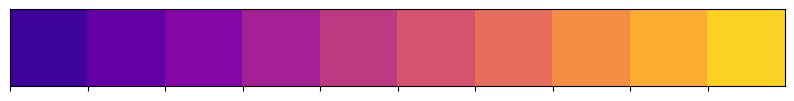

In [ ]:

# 获取所有可用的调色板名称
palette_names = sns.palettes.SEABORN_PALETTES.keys()
print("Available Seaborn palettes:", palette_names)

import matplotlib.pyplot as plt
import matplotlib.cm as cm

cmap_names = plt.colormaps()
print("可用的 Matplotlib 颜色地图:", cmap_names)

# 查看 Seaborn 的调色板
palette = sns.color_palette("plasma", n_colors=10)  # 选择你需要的调色板和颜色数量
print(palette.as_hex())

# 绘制调色板的颜色示例
sns.palplot(palette)
plt.show()


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 36 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'C', 'D', 'J', 'M', 'O', 'P', 'U', 'X', 'a', 'b', 'd', 'e', 'f', 'five', 'g', 'h', 'i', 'l', 'm', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'space', 't', 'three', 'two', 'u', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 24, 36, 38, 39, 45, 48, 50, 51, 56, 59, 68, 69, 71, 72, 73, 74, 75, 76, 79, 80, 81, 82, 83, 85, 86, 87, 88, 237]
INFO:fontTools.subset:Closed glyph list over '

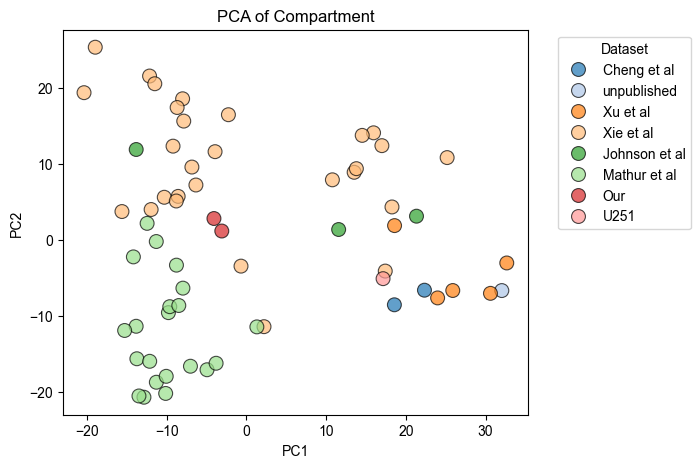

In [ ]:
X_pca.rename(columns={X_pca.columns[i]: f'PC{i+1}' for i in range(15)}, inplace=True)
plt.figure(figsize=(6, 5))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=X_pca, palette='tab20', s=100, alpha=0.7, edgecolor='k')
'''
# 为每个点添加样本名称标记
for i in range(X_pca.shape[0]):
    plt.text(x=X_pca['PC1'][i], y=X_pca['PC2'][i], s=X_pca.index[i],
             fontdict=dict(color='black', size=10), 
             bbox=dict(facecolor='yellow', alpha=0.5, boxstyle='round,pad=0.3'))

'''

plt.title('PCA of Compartment')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig(f'/cluster/home/futing/Project/GBM/HiC/09insulation/00plot/PC1/PC1_scatter.pdf', format='pdf', dpi=500, bbox_inches='tight', pad_inches=0.5)

#### Kmean

In [ ]:
def kmeans(data, k, max_iters=200):
    # 1. 初始化聚类中心
    centroids = data[np.random.choice(data.shape[0], k, replace=False)]

    for _ in range(max_iters):
        # 2. 计算每个数据点到每个聚类中心的距离
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        
        # 3. 分配数据点到最近的聚类中心
        labels = np.argmin(distances, axis=1)
        
        # 4. 更新聚类中心
        new_centroids = np.array([data[labels == i].mean(0) for i in range(k)])
        
        # 5. 检查是否收敛
        if np.all(new_centroids == centroids):
            break
        
        centroids = new_centroids
    return centroids, labels


In [ ]:
# all_sig_U 行是样本list，列是特征
projected_data = X_pca.iloc[:,0:15].values
np.random.seed(0)
#X = all_sig_U.T
# X 行是样本，列是特征
X = projected_data
centroids, clust_labels = kmeans(X, k=4)

# 输出结果
print("聚类标签：", clust_labels)
print("聚类中心：", centroids)

聚类标签： [2 2 2 0 1 0 0 0 0 1 0 0 3 3 0 3 3 2 3 0 0 0 0 0 3 3 3 2 0 2 3 0 0 2 2 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 2 2 2 2]
聚类中心： [[-9.93354137e+00  1.17127471e+01  5.13459126e+00  2.68061026e-01
   2.61002183e+00 -5.02600697e-01 -4.48562549e-01 -1.91370178e+00
   4.44882920e-01  1.47563920e+00 -1.39803292e-02 -7.33409007e-02
  -1.76668006e-01  4.15337743e-01  6.07196567e-01]
 [-8.96648837e+00 -1.21234551e+01 -1.96902068e+00 -1.40939545e+00
  -7.02407568e-01  3.63733374e-01  1.91022500e-01  1.34195593e+00
  -1.04709496e+00 -5.15616508e-01  2.54494201e-02  7.91531584e-03
  -8.07463313e-01  4.40060152e-01 -3.17046681e-01]
 [ 2.33871496e+01 -2.74228982e+00  5.46291369e+00 -3.44321659e+00
   1.24549106e-01 -4.87107603e-01 -4.71174154e-01 -1.62055208e+00
   1.02559629e+00  5.46469074e-01  4.21531456e-01 -4.71069021e-01
   7.58271767e-01 -1.13016294e+00  3.12624059e-01]
 [ 9.10745391e+00  8.86928723e+00 -1.39174063e+01  7.85281735e+00
  -3.97295408e+00  8.75519762e-01  1.16060638e

In [ ]:
X_pca['label']=clust_labels
X_pca.to_csv('/cluster/home/futing/Project/GBM/HiC/09insulation/00plot/PC1/PC_E1.txt',sep='\t',header=True)
E1_fil.to_csv('/cluster/home/futing/Project/GBM/HiC/09insulation/00plot/PC1/E1_fil.txt',sep='\t',header=True)

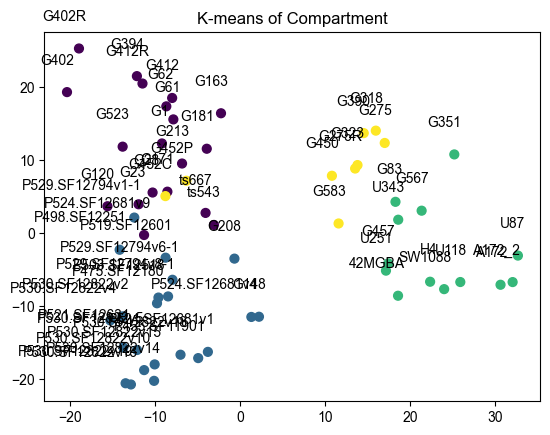

In [ ]:
from sklearn.preprocessing import LabelEncoder
labels=list(E1_fil.columns)
# 标签编码
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# 绘制散点图
plt.scatter(X[:, 0], X[:, 1], c=clust_labels, s=40, cmap='viridis')

for i, label in enumerate(labels):
    # 选择需要标记的点
    plt.annotate(label, (X[i][0], X[i][1]), textcoords="offset points", xytext=(5,20), ha='right')
plt.title("K-means of Compartment")
plt.show()

In [ ]:

def pca(X, num_components):
    # 1. 标准化数据
    X_normalized = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    # 2. 计算协方差矩阵
    covariance_matrix = np.cov(X_normalized, rowvar=False)
    # 3. 计算特征值和特征向量
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    # 4. 选择前num_components个特征向量
    top_eigenvectors = eigenvectors[:, :num_components]
    # 5. 投影数据到低维空间
    projected_data = np.dot(X_normalized, top_eigenvectors)
    
    return projected_data

In [ ]:
X = pca(X, num_components=15)

## 树状图

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 48 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'F', 'G', 'H', 'I', 'M', 'P', 'R', 'S', 'U', 'W', 'a', 'c', 'd', 'e', 'eight', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 36, 37, 38, 39, 41, 42, 43, 44, 48, 

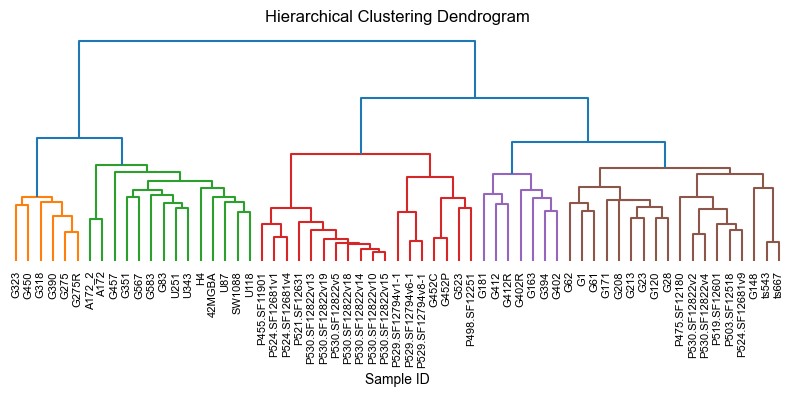

In [ ]:

from scipy.cluster.hierarchy import dendrogram, linkage

# all=all.fillna(0)
plt.figure(figsize=(10, 3))
data = E1_fil.T
data = np.nan_to_num(data, nan=np.nanmean(data,axis=0), posinf=np.max(data[np.isfinite(data)]))
# 使用 'ward' 方法进行层次聚类
linked = linkage(data, method='ward')

# 绘制树状图
def custom_color_func(linkage_matrix, color_threshold):
    def color_func(dist):
        if dist[2] < color_threshold:
            return 'blue'  # 设定距离小于阈值时的颜色
        else:
            return 'red'   # 设定距离大于阈值时的颜色

    return lambda x: color_func(x)  # x[2] 是距离

dendrogram(linked,
           orientation='top',
           labels=all.columns,
           distance_sort='ascending',
           show_leaf_counts=True,
           color_threshold=np.max(linked[:, 2]) / 2 )# 设置颜色阈值)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample ID')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.yticks([])
plt.xticks(fontsize=8)
plt.savefig(f'/cluster/home/futing/Project/GBM/HiC/09insulation/00plot/PC1/PC1_dendrogram.pdf', format='pdf', dpi=500, bbox_inches='tight', pad_inches=0.5)

# loop 聚类

In [ ]:
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score

# 假设我们有两个矩阵：PC1矩阵和隔离分数矩阵（每个bin为行，每个样本为列）
# 读取PC1和隔离分数数据
pc1_data = pd.read_csv('pc1_data.csv', index_col=0)  # 行为基因组bin，列为样本
insulation_data = pd.read_csv('insulation_data.csv', index_col=0)

# 计算PC1和隔离分数的成对相关性
def pairwise_correlation(matrix):
    return matrix.corr(method='pearson')

pc1_corr = pairwise_correlation(pc1_data)
insulation_corr = pairwise_correlation(insulation_data)

# 读取环数据并计算Jaccard相似性
# 假设loops_data是每个样本对应的一组环数据，每组为一组环的起点和终点(anchor midpoints)
# 格式: {sample: [(anchor1_mid, anchor2_mid), ...]}
loops_data = {
    'sample1': [(100000, 200000), (300000, 400000)],
    'sample2': [(105000, 205000), (350000, 450000)],
    # 更多样本...
}

def calculate_jaccard_similarity(loops1, loops2, threshold=50000):
    def is_same_loop(loop1, loop2, threshold):
        return abs(loop1[0] - loop2[0]) < threshold and abs(loop1[1] - loop2[1]) < threshold

    matches = sum(1 for l1 in loops1 for l2 in loops2 if is_same_loop(l1, l2, threshold))
    union_size = len(loops1) + len(loops2) - matches
    return matches / union_size if union_size > 0 else 0

# 计算所有样本之间的环Jaccard相似性
samples = list(loops_data.keys())
loop_similarity_matrix = np.zeros((len(samples), len(samples)))

for i, s1 in enumerate(samples):
    for j, s2 in enumerate(samples):
        if i <= j:
            similarity = calculate_jaccard_similarity(loops_data[s1], loops_data[s2])
            loop_similarity_matrix[i, j] = similarity
            loop_similarity_matrix[j, i] = similarity

loop_similarity_df = pd.DataFrame(loop_similarity_matrix, index=samples, columns=samples)

# 合并所有相似性矩阵：PC1, Insulation, Loops (可以选择加权平均或其他方式)
average_similarity_matrix = (pc1_corr + insulation_corr + loop_similarity_df) / 3

# 计算距离矩阵
distance_matrix = 1 - average_similarity_matrix

# 使用层次聚类
Z = linkage(pdist(distance_matrix), method='average')

# 绘制聚类树
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=average_similarity_matrix.index)
plt.title("Hierarchical Clustering of GSC Subtypes")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()


# get sig features between stem and unknown
wilcoxon 秩和检验

In [ ]:
#stem_bound.columns=['G523','G567','G583','ts543','ts667']
stem.columns=['G523','G567','G583','ts543','ts667']
nonstem.columns=['A172','GB176','GB180','GB182','GB183','GB238','SW1088','U118','U343','U87']

In [ ]:
all=pd.concat([stem,nonstem],axis=1)
filcon=(all==0).sum(axis=1) <= 8 # 去掉一半为0的行
all_fil=all.loc[filcon,:] #去掉一半为0的行
all_fi2=all.loc[(all != 0).any(axis=1),:] #去掉全为0的行

In [ ]:
data1=stem.loc[all_fil.index,:].T
data2=nonstem.loc[all_fil.index,:].T
significant_features = []
p_values = []

# 对每个特征进行Wilcoxon秩和检验
for i in range(data1.shape[1]):
    feature1 = data1.iloc[:, i]
    feature2 = data2.iloc[:, i]
    stat, p_value = mannwhitneyu(feature1, feature2)
    if p_value < 0.05:  # 使用显著性水平0.05
        significant_features.append(i)
        p_values.append(p_value)

# 输出结果
print("显著差异的特征索引：", significant_features)
print("对应的p值：", p_values)

显著差异的特征索引： [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 69, 73, 75, 161, 162, 163, 164, 165, 166, 167, 168, 170, 171, 192, 193, 194, 197, 198, 199, 200, 201, 202, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 347, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 474, 501, 502, 503, 504, 505, 506, 507, 508, 562, 563, 564, 565, 566, 567, 568, 570, 648, 651, 652, 653, 654, 656, 661, 701, 702, 703, 704, 872, 873, 874, 875, 934, 936, 941, 942, 943, 944, 945, 946, 947, 948, 993, 994, 995, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1171, 1201, 1202, 1203, 1204, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1321, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1443, 1444, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 14

In [ ]:
all_sig_U=all_fil.iloc[significant_features,:].T
all_sig_U.T.head()

,G523,G567,G583,ts543,ts667,A172,GB176,GB180,GB182,GB183,GB238,SW1088,U118,U343,U87
16,-1.484269,-1.193155,-0.660383,-1.426398,-1.423592,-2.228293,-5.862947,-3.594150,-6.132371,-4.957450,-4.065012,-2.003247,-1.741638,-1.872590,-2.513340
17,-1.175262,-0.937204,-0.447496,-0.945765,-0.989215,-1.586285,-4.277985,-3.038334,-3.839589,-4.957450,-3.065012,-1.420523,-1.198883,-1.610399,-1.688824
18,-0.851815,-0.735837,-0.303698,-0.600213,-0.644225,-1.090380,-3.055592,-2.949525,-3.345775,-3.372488,-2.495764,-1.042356,-0.862197,-1.278941,-1.155848
19,-0.569902,-0.555230,-0.185798,-0.315505,-0.425573,-0.822577,-2.693022,-2.949525,-2.686115,-2.957450,-2.170679,-0.685014,-0.612181,-0.932415,-0.868399
20,-0.375524,-0.394737,-0.075527,-0.110920,-0.198185,-0.579086,-1.956057,-2.437107,-2.335358,-2.218682,-1.681653,-0.487877,-0.418189,-0.674737,-0.603000


In [ ]:
all_sig_U.T.to_csv("/cluster/home/futing/Project/GBM/HiC/02data/0350k/insulation/all_sig_U.txt",sep="\t",header=True)
#all_sig_U=pd.read_csv("/cluster/home/futing/Project/GBM/HiC/02data/0350k/insulation/all_sig_U.txt",sep="\t")

# other

In [62]:
import os
chrom_list=pd.DataFrame()
input_dir='/cluster/home/futing/Project/GBM/HiC/02data/03cool/5000'
    
# 遍历所有 .cool 文件
for file_name in os.listdir(input_dir):
    if file_name.endswith(".cool"):
        data_path = os.path.join(input_dir, file_name)
        c=cooler.Cooler(data_path)
        name = data_path.split('/')[-1].split('_')[0]
        print(name)
        if len(c.bins()[:]['chrom'].unique().tolist()) != 24:
            print(f"Error: {name} has missing chromosomes")
        else:
            chrom_list[name]=c.bins()[:]['chrom'].unique().tolist()

chrom_list.to_csv('chrom_list.csv')

G163
P530.SF12822v10
G62
G83
42MGBA
G450
G208R2
P475.SF12180
P524.SF12681v4
P529.SF12794v8-1
NPC
P521.SF12631
P524.SF12681v1
SW1088
G213
ts667
ts667
U118
GBMraw
pHGG
GBMstem
ts543
G567
G583
G1
G390
G148
G171
G181
G394
G120
G213R1
G412R
G452C
G452P
G23
G318
G208R1
G412
H4
G208
P530.SF12822v15
P498.SF12251
NPC
G523
GB176
GB180
GB182
GB183
GB238
P529.SF12794v6-1
P530.SF12822v18
A172
ts543
ts543
U343
U87
GBMmerge
ipsc
GBMour
GBM
ts667
U251
G351
G402
G28
G323
G275R
G402R
G275
G61
G213R2
G457
P455.SF11901
A172
Error: A172 has missing chromosomes
P530.SF12822v19
P530.SF12822v13
P503.SF12518
P530.SF12822v4
P519.SF12601
P524.SF12681v9
P530.SF12822v5
P530.SF12822v2
P530.SF12822v14
P529.SF12794v1-1
iPSC


In [41]:
namelist=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/02data/03cool/GBM.txt',header=None)

In [5]:
chrom_list=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/02data/03cool/merge/50000/chrom_list_50000.csv')
chrom_list.T.value_counts()

0     1     2     3     4     5     6     7     8     9      10     11     12     13     14     15     16     17     18     19     20     21     22     23   
chr1  chr2  chr3  chr4  chr5  chr6  chr7  chrX  chr8  chr9   chr11  chr10  chr12  chr13  chr14  chr15  chr16  chr17  chr18  chr20  chr19  chrY   chr22  chr21    58
                                          chr8  chr9  chr10  chr11  chr12  chr13  chr14  chr15  chr16  chr17  chr18  chr19  chr20  chr21  chr22  chrX   chrY     22
Name: count, dtype: int64

In [6]:
part1=chrom_list.loc[:,chrom_list.iloc[7,:]=='chrX']
part2=chrom_list.loc[:,chrom_list.iloc[7,:]=='chr8']

In [7]:
part2.columns

Index(['GBM', 'A172', 'SW1088', 'ts543', 'ts667', 'U118', 'U343', 'GBMmerge',
       'ipsc', 'pHGG', 'GBMstem', 'G567', 'G583', 'G523', 'GB176', 'GB180',
       'GB182', 'GB183', 'GB238', 'U87', 'GBMraw', 'GBMour'],
      dtype='object')

In [29]:
datapath='/cluster/home/futing/Project/GBM/RNA/iPSC_new/gene-TPM-matrix.txt'
name='iPSC_new'
RNA = pd.read_csv(datapath,sep='\t',header=None)
RNA_mean = RNA.iloc[:, 1:].mean(axis=1).round(3)

# 将基因名和均值保存到新的文件中
RNA_result = pd.DataFrame({
    'Gene': RNA.iloc[:, 0],  # 基因名
    'Mean': RNA_mean         # 对应的均值
})

RNA_result.to_csv(f'{name}_mean.bed',sep='\t',header=False,index=False)


#### chrom name

In [3]:
chrlistlong=pd.read_csv('/cluster/home/futing/software/juicer_CPU/restriction_sites/hg38.genome',sep='\t',header=None)[0].tolist()


In [6]:
c=cooler.Cooler('/cluster/home/futing/Project/GBM/HiC/02data/04mcool/01GBM/P455.SF11901.mcool::/resolutions/5000')
bins = c.bins()[:]
chroms = bins['chrom'].unique().tolist()

In [7]:
chroms != chrlistlong

True

In [9]:
diff = set(chrlistlong) - set(chroms)


In [11]:
len(chroms),len(chrlistlong)

(194, 194)

In [12]:
dif = pd.DataFrame({'chrom': chroms,'chrlistlong':chrlistlong})

In [14]:
dif[dif['chrom'] != dif['chrlistlong']]

,chrom,chrlistlong
25,chrGL000008.2,GL000008.2
26,chrGL000009.2,GL000009.2
27,chrGL000194.1,GL000194.1
28,chrGL000195.1,GL000195.1
29,chrGL000205.2,GL000205.2
...,...,...
189,chrKI270753.1,KI270753.1
190,chrKI270754.1,KI270754.1
191,chrKI270755.1,KI270755.1
192,chrKI270756.1,KI270756.1


In [16]:
import pandas as pd

# 如果 chroms 是列表，转换为 DataFrame
chroms_df = pd.DataFrame(chroms)

# 然后保存为 txt 文件
chroms_df.to_csv('/cluster/home/futing/Project/GBM/HiC/02data/05file_transform/chrlistchr.txt', sep='\t', header=False, index=False)



# 算一下contacts

In [ ]:
A172_50k=cooler.Cooler('/cluster/home/futing/Project/GBM/HiC/02data/04mcool/01GBM/A172.mcool::resolutions/50000')
A172_10k=cooler.Cooler('/cluster/home/futing/Project/GBM/HiC/02data/04mcool/01GBM/A172.mcool::resolutions/10000')

In [ ]:
A172_50k.pixels()[:]['count'].sum(),A172_10k.pixels()[:]['count'].sum()

105835864

In [ ]:
# 获取每个染色体的行号范围
result = []
for chrom, group in A172_50k.bins()[:].groupby('chrom'):
    start_row = group.index.min()   # 行号从1开始
    end_row = group.index.max()    # 行号从1开始
    num=end_row-start_row+1
    result.append([chrom, start_row, end_row,num])

# 创建新的 DataFrame
result_df = pd.DataFrame(result, columns=['Chrom', 'Start', 'End','num'])

/tmp/ipykernel_164972/2800037164.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for chrom, group in A172_50k.bins()[:].groupby('chrom'):


In [ ]:
A172_50k.bins()[:]['chrom'].value_counts().sort_index()

chrom
1     4980
2     4844
3     3966
4     3805
5     3631
6     3417
7     3187
8     2903
9     2768
10    2676
11    2702
12    2666
13    2288
14    2141
15    2040
16    1807
17    1666
18    1608
19    1173
20    1289
21     935
22    1017
X     3121
Y     1145
M        1
Name: count, dtype: int64

In [ ]:
result_df

,Chrom,Start,End,num
0,1,0,4979,4980
1,2,4980,9823,4844
2,3,9824,13789,3966
3,4,13790,17594,3805
4,5,17595,21225,3631
5,6,21226,24642,3417
6,7,24643,27829,3187
7,8,27830,30732,2903
8,9,30733,33500,2768
9,10,33501,36176,2676


# cooltools

In [5]:
G583_ex = pd.read_csv('/cluster/home/futing/Project/GBM/HiC/10loop/cooltools/G583/expected.cis.25000.tsv',sep='\t')

In [13]:
G583_ex[G583_ex['count.avg'] == 0]

,region1,region2,dist,n_valid,count.sum,balanced.sum,count.avg,balanced.avg
4670,chr1_p,chr1_p,4670,49,0.0,0.0,0.0,0.0
4706,chr1_p,chr1_p,4706,30,0.0,0.0,0.0,0.0
4725,chr1_p,chr1_p,4725,14,0.0,0.0,0.0,0.0
4730,chr1_p,chr1_p,4730,10,0.0,0.0,0.0,0.0
4731,chr1_p,chr1_p,4731,10,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
123501,chrY_q,chrY_q,1834,3,0.0,0.0,0.0,0.0
123505,chrY_q,chrY_q,1838,3,0.0,0.0,0.0,0.0
123511,chrY_q,chrY_q,1844,2,0.0,0.0,0.0,0.0
123512,chrY_q,chrY_q,1845,1,0.0,0.0,0.0,0.0


In [11]:
G583_5000=pd.read_csv('/cluster/home/futing/Project/GBM/HiC/10loop/cooltools/G583/expected.cis.5000.tsv',sep='\t')
G583_5000[G583_5000['count.avg'] == 0]

,region1,region2,dist,n_valid,count.sum,balanced.sum,count.avg,balanced.avg
22003,chr1_p,chr1_p,22003,1653,0.0,0.0,0.0,0.0
22231,chr1_p,chr1_p,22231,1427,0.0,0.0,0.0,0.0
22316,chr1_p,chr1_p,22316,1349,0.0,0.0,0.0,0.0
22326,chr1_p,chr1_p,22326,1337,0.0,0.0,0.0,0.0
22370,chr1_p,chr1_p,22370,1294,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
617542,chrY_q,chrY_q,9243,5,0.0,0.0,0.0,0.0
617543,chrY_q,chrY_q,9244,4,0.0,0.0,0.0,0.0
617544,chrY_q,chrY_q,9245,3,0.0,0.0,0.0,0.0
617545,chrY_q,chrY_q,9246,2,0.0,0.0,0.0,0.0


In [14]:
G583=cooler.Cooler('/cluster/home/futing/Project/GBM/HiC/02data/04mcool/01GBM/G583.mcool::/resolutions/25000')

In [16]:
import cooltools
# Use bioframe to fetch the genomic features from the UCSC.
hg38_chromsizes = bioframe.fetch_chromsizes('hg38')
hg38_cens = bioframe.fetch_centromeres('hg38')
hg38_arms = bioframe.make_chromarms(hg38_chromsizes, hg38_cens)

# Select only chromosomes that are present in the cooler. 
hg38_arms = hg38_arms.set_index("chrom").loc[G583.chromnames].reset_index()

In [22]:
dots_df = cooltools.dots(
    G583,
    expected=G583_ex,
    view_df=hg38_arms,
    # how far from the main diagonal to call dots:
    max_loci_separation=10_000_000,
    n_lambda_bins=50,
    nproc=4,
)

INFO:root:Using recommended donut-based kernels with w=3, p=1 for binsize=25000
INFO:root:convolving 1781 tiles to build histograms for lambda-bins
INFO:root:creating a Pool of 4 workers to tackle 1781 tiles
INFO:root:Done building histograms in 97.660 sec ...
INFO:root:Determined thresholds for every lambda-bin ...
INFO:root:convolving 1781 tiles to extract enriched pixels
INFO:root:creating a Pool of 4 workers to tackle 1781 tiles
INFO:root:Done extracting enriched pixels in 75.636 sec ...
INFO:root:Begin post-processing of 21829 filtered pixels
INFO:root:preparing to extract needed q-values ...
INFO:root:clustering enriched pixels in region: chr10_p
INFO:root:detected 123 clusters of 1.68+/-0.84 size
INFO:root:clustering enriched pixels in region: chr10_q
INFO:root:detected 248 clusters of 1.59+/-0.85 size
INFO:root:clustering enriched pixels in region: chr11_p
INFO:root:detected 232 clusters of 1.76+/-0.91 size
INFO:root:clustering enriched pixels in region: chr11_q
INFO:root:detec

In [23]:
dots_df.to_csv('/cluster/home/futing/Project/GBM/HiC/10loop/cooltools/G583/dots_25000.tsv',sep='\t',index=False)